# Simple example

This Section demonstrates how to apply our `pymcdm` library in a simple case. It will be demonstrated on an artificial decision matrix with 3 criteria and 4 alternatives.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from pymcdm.methods import TOPSIS
from pymcdm.helpers import rrankdata
from pymcdm.correlations import correlation_matrix, weighted_spearman

In [2]:
if not os.path.isdir('./images'):
    os.mkdir('./images')

Definition of a decision matrix. Usually, you will want to read one from the file.

In [3]:
alts = np.array([
    [4, 4, 0.2],
    [1, 5, 0.5],
    [3, 2, 0.3],
    [4, 2, 0.5]
])

Define the vector of weights. The Sum of the weights should be equal 1.

In [4]:
weights = np.array([0.3, 0.5, 0.2])

Define criteria types. The first and third are benefits, so we have 1 in `types` vector, and the second one is a cost, so we have -1 in this vector.

In [5]:
types = np.array([1, -1, 1])

In the `pymcdm` library, every MCDA method is a class, so we first need to crate the object of out method. Some methods allow a certain degree of customization, e.g., the TOPSIS method allows to change normalization method in the constructor. Default normalization is a min-max normalization.

In [6]:
topsis = TOPSIS()

Next, we want to apply the chosen method to our MCDA problem.

In [7]:
pref = topsis(alts, weights, types)
print(np.round(pref, 4))

[0.4689 0.2554 0.765  1.    ]


So we have calculated the preferences of the given four alternatives. The last one has a preference equal to 1, so this one is the best alternative. For the TOPSIS method, the most significant value of the preference means a better alternative. For other methods, you should check our documentation or methods described.

The last thing we want to do here is building of the ranking. We will use `rranking` method from the `helpers` module of the `pymcdm` library to rank those alternatives from the most significant preference value to the lowest preference value.

In [8]:
rank = rrankdata(pref)
print(rank)

[3. 4. 2. 1.]


Alternatively, every method's object has a `rank()` method, which allows correctly ranking obtained preference.

In [9]:
rank = topsis.rank(pref)
print(rank)

[3. 4. 2. 1.]


So our ranking is `[3, 4, 2, 1]`, but how to interpret those values? The first value in the ranking is 3, corresponding to the first alternative, so the alternative $A_1$ has position 3 in the ranking. Alternative $A_2$ has 4th position, $A_3$ has 2nd position, and $A_4$ has the first position in the final ranking.

# Using several MCDA methods for a decision problem

In this example, we want to show how to apply several MCDA methods to a decision problem. We will show how to apply TOPSIS, MABAC COMET, and SPOTIS.

We show how to read data from csv using pandas, and then we need to create objects of the chosen methods. Because of the uniform interface of every method, we could create a list of the MCDA methods objects and then apply those methods using for loop.

In [10]:
import pandas as pd

from pymcdm.methods import TOPSIS, MABAC, COMET, SPOTIS
from pymcdm import weights as w
from pymcdm.helpers import rankdata, rrankdata

In [11]:
df = pd.read_csv('vans.csv')

# Use only columns with numerical data
alts = df[df.columns[3:]].to_numpy()

In [12]:
df

,code,name,manufacturer,carryfying capacity,max velocity,travel range,engine power,engine torque,battery charging 100%,battery charging 80%,battery capacity,price
0,A1,EVI MD,Electric Vehicles International,3000,96,145,200,610,10.0,120,99.0,120.0
1,A2,EVI Walk-In Van,Electric Vehicles International/Freightliner ...,2000,100,145,200,610,10.0,120,99.0,90.0
2,A3,e-NV200+,Nissan,705,120,170,80,270,4.0,30,24.0,25.0
3,A4,e-Wolf Omega 0.7,e-Wolf,613,140,180,140,400,8.0,40,24.2,50.0
4,A5,Minicab-MiEV Truck,Mitsubishi Motors Corp.,350,100,110,30,196,4.5,15,10.5,12.9
5,A6,Mitsubishi Minicab-MiEV (10.5 kWh),Mitsubishi Motors Corp.,350,100,100,30,196,4.5,15,10.5,15.5
6,A7,Mitsubishi Minicab-MiEV (16kWh),Mitsubishi Motors Corp.,350,100,150,30,196,7.0,35,16.0,18.7
7,A8,Partner Panel Van,Peugeot,635,110,170,49,200,8.0,35,22.5,31.5
8,A9,Phoenix Motorcars SUV,Phoenix Motorcars,340,150,160,110,500,6.0,10,35.0,45.0
9,A10,Piaggio Porter electric-power,Piaggio Porter,750,57,110,10,80,8.0,120,35.0,24.4


In [13]:
# Define weights and criteria types.
weights = w.entropy_weights(alts)
types = np.array([1, 1, 1, 1, 1, -1, -1, 1, -1])

# To use the COMET method, we need to define characteristic values.
# It could be achieved using `make_cvalues` static method of a COMET object.
# Alternatively, characteristic values should be provided by an expert.
cvalues = COMET.make_cvalues(alts)

# COMET method also uses a rate function to rate characteristic objects.
# To automatize the process, `topsis_rate_function` could be used.
rate_function = COMET.topsis_rate_function(weights, types)

# A similar thing should be done for the SPOTIS method. For this method decision
# bounds should be provided. Bounds could be defined by a decision maker or
# calculated automatically from the data.
bounds = SPOTIS.make_bounds(alts)

Finally, we could define a list of chosen methods.

In [14]:
methods = [
    TOPSIS(),
    MABAC(),
    COMET(cvalues, rate_function=rate_function),
    SPOTIS()
]

method_names = ['TOPSIS', 'MABAC', 'COMET', 'SPOTIS']

Now we want to apply those methods in the for loop to get rankings and the preferences for this decision problem.

In [15]:
prefs = []
ranks = []

for method in methods:
    pref = method(alts, weights, types, bounds=bounds)
    rank = method.rank(pref)
    
    prefs.append(pref)
    ranks.append(rank)

And then, we want to construct and show tables with preferences and rankings for every alternative.

In [16]:
a = [f'$A_{{{i+1}}}$' for i in range(len(prefs[0]))]
pd.DataFrame(zip(*prefs), columns=method_names, index=a).round(3)

,TOPSIS,MABAC,COMET,SPOTIS
$A_{1}$,0.576,0.229,0.746,0.368
$A_{2}$,0.562,0.199,0.691,0.397
$A_{3}$,0.459,0.068,0.396,0.529
$A_{4}$,0.464,0.073,0.399,0.523
$A_{5}$,0.430,-0.013,0.282,0.610
$A_{6}$,0.427,-0.018,0.276,0.614
$A_{7}$,0.398,-0.049,0.221,0.646
$A_{8}$,0.412,-0.016,0.278,0.613
$A_{9}$,0.498,0.128,0.497,0.468
$A_{10}$,0.300,-0.185,0.076,0.782


In [17]:
pd.DataFrame(zip(*ranks), columns=method_names, index=a).astype('int')

,TOPSIS,MABAC,COMET,SPOTIS
$A_{1}$,1,1,1,1
$A_{2}$,2,2,2,2
$A_{3}$,5,5,5,5
$A_{4}$,4,4,4,4
$A_{5}$,6,6,6,6
$A_{6}$,7,8,8,8
$A_{7}$,9,9,9,9
$A_{8}$,8,7,7,7
$A_{9}$,3,3,3,3
$A_{10}$,10,10,10,10


# Visualisation of the rankings

The `pymcdm` library also includes more than ten ways to visualize results obtained with different methods. First, we will demonstrate four ways to visualize the differences between different rankings.

The first two ways are a `ranking_bar` and `ranking_flows` functions from `visuals` sub-module. You could just use those functions or provide an Axes on which those plots should be drawn.

In [18]:
from pymcdm import visuals

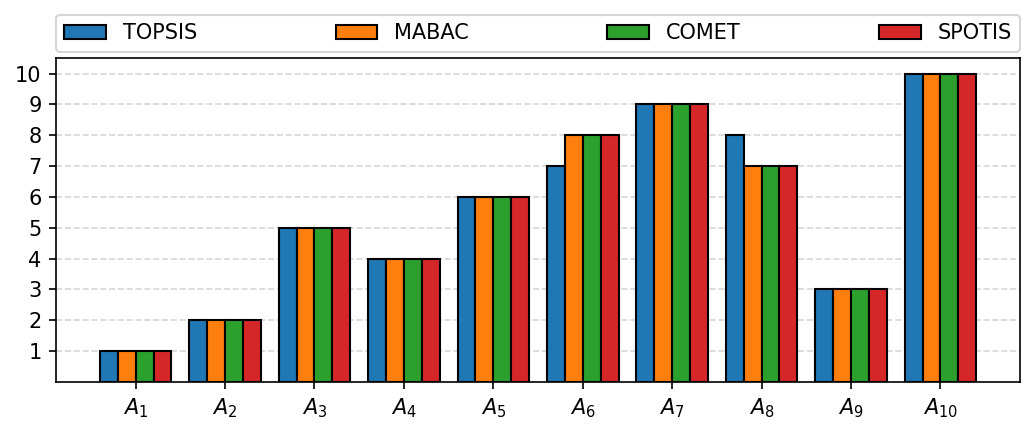

In [19]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.ranking_bar(ranks, labels=method_names, ax=ax)
plt.savefig('images/ranking_bar.pdf', bbox_inches='tight')
plt.show()

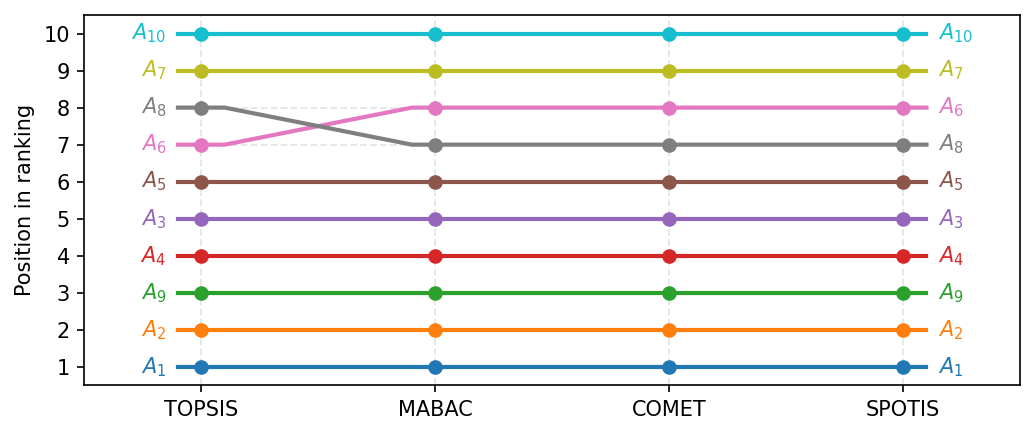

In [20]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)
visuals.ranking_flows(ranks, labels=method_names, better_grid=True, ax=ax)
plt.savefig('images/ranking_flows.pdf', bbox_inches='tight')
plt.show()

The next one is a `polar_plot` function, which creates a web plot of different rankings. It would help if you created Axes with an `'polar'` projection, or this function will not work.

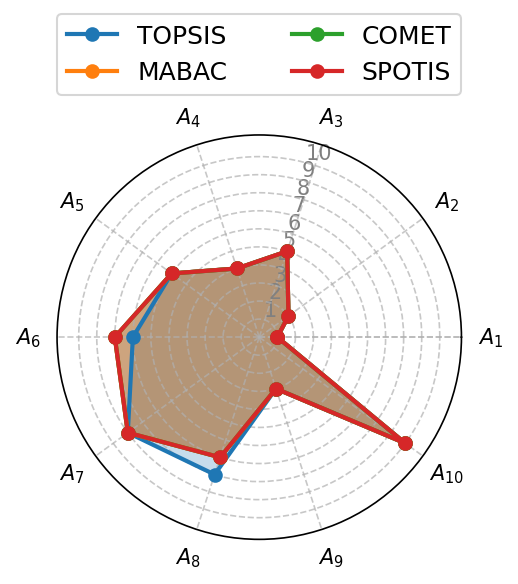

In [21]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True, subplot_kw=dict(projection='polar'))
visuals.polar_plot(ranks, labels=method_names, legend_ncol=2, ax=ax)
plt.savefig('images/polar_plot.pdf', bbox_inches='tight')
plt.show()

The next is a `ranking_scatter` function, which visualizes your rankings as scatter points. This function could visualize only two rankings.

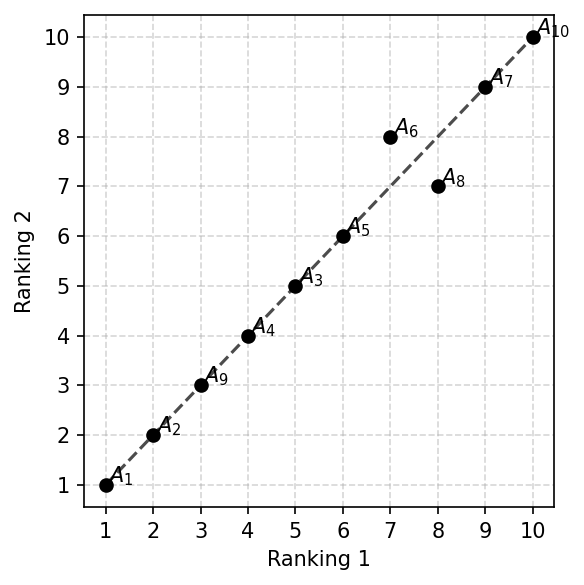

In [22]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.ranking_scatter(ranks[0], ranks[1], ax=ax)
plt.savefig('images/ranking_scatter.pdf', bbox_inches='tight')
plt.show()


It is also possible to visualize the correlations between the rankings as change of the correlations as it showed below.

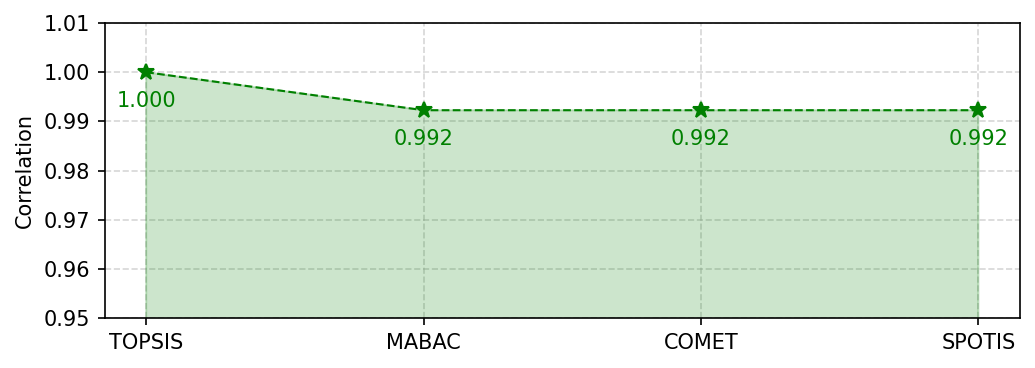

In [23]:
corrs = []
for r in ranks:
    corrs.append(weighted_spearman(ranks[0], r))

fig, ax = plt.subplots(figsize=(7, 2.5), dpi=150, tight_layout=True)
visuals.correlation_plot(corrs, ylim=(0.95, 1.01), space_multiplier=0.5, labels=method_names, ax=ax)
plt.savefig('images/correlation_plot.pdf', bbox_inches='tight')
plt.show()

There is also a function which combine `correlation_plot` as well as `ranking_flows` function, which allow visualize it in simply way.

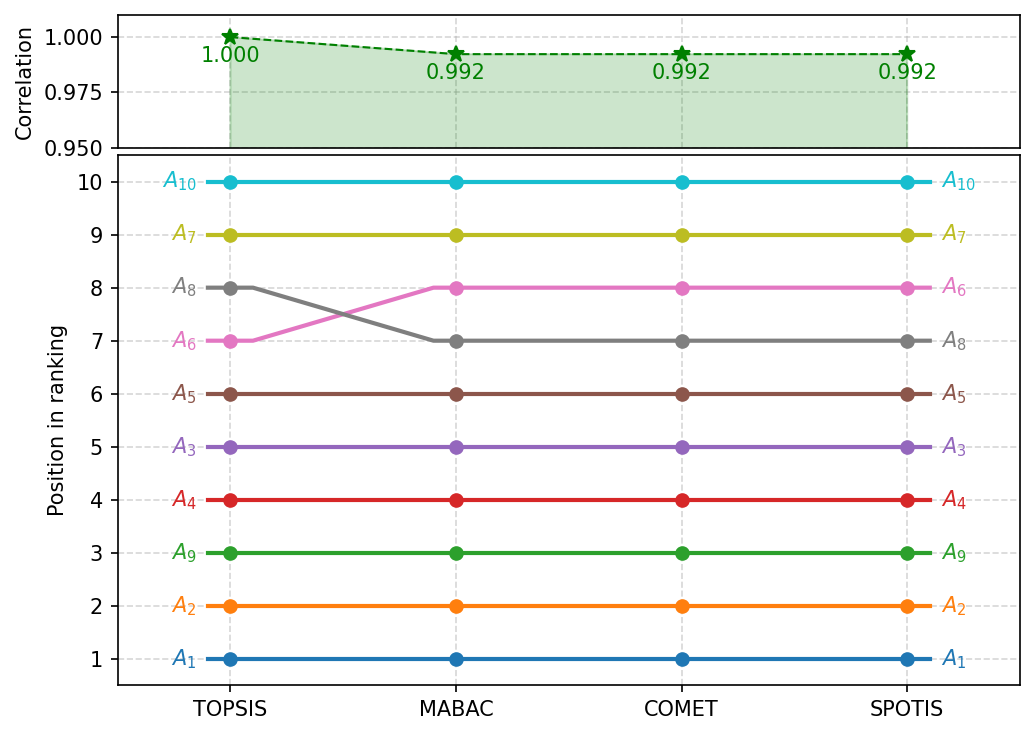

In [24]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150, tight_layout=True)
visuals.rankings_flow_correlation(ranks,
                                  corrs,
                                  labels=method_names,
                                  correlation_plot_kwargs=dict(space_multiplier=0.5, ylim=(0.95, 1.01)),
                                  ax=ax)
plt.savefig('images/ranking_flow_correlation.pdf', bbox_inches='tight')
plt.show()

# Visualization of the correlations between rankings

The following function allows us to visualize the correlations between several rankings.

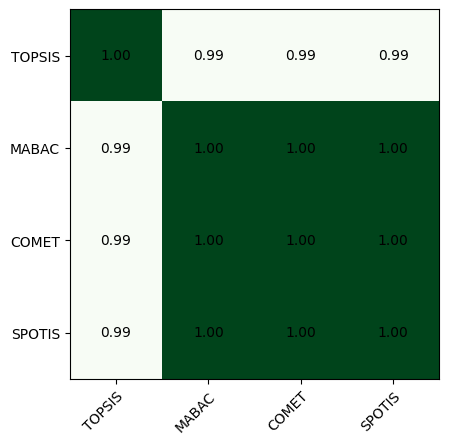

In [25]:
# Basic usage
corr_matrix = correlation_matrix(ranks, weighted_spearman)

visuals.correlation_heatmap(corr_matrix, labels=method_names)
plt.savefig('images/heatmap1.pdf', bbox_inches='tight')
plt.show()

Those plots are highly customizable, you could see more comlex example below.

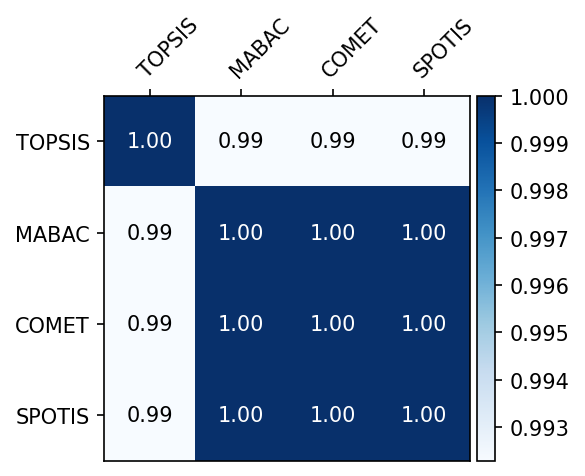

In [26]:
# More complex example
corr_matrix = correlation_matrix(ranks, weighted_spearman)

fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.correlation_heatmap(corr_matrix,
                            labels=method_names,
                            labeltop=True,
                            cmap='Blues',
                            adapt_text_colors=['k', 'w'],
                            colorbar=True,
                            ax=ax)
plt.savefig('images/heatmap2.pdf', bbox_inches='tight')
plt.show()

# Rank reversal visualization

With `rankings_flows()` function we also can visualize rank reversal for methods which are suspectable to it. See the example below.

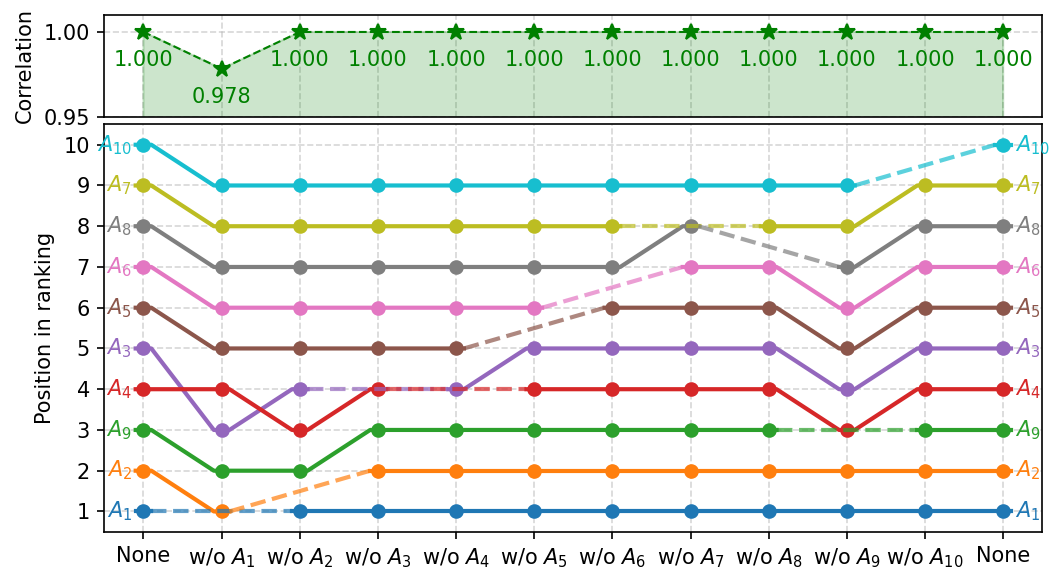

In [27]:
from pymcdm.helpers import leave_one_out_rr

topsis = TOPSIS()

rankings, corrs, labels = leave_one_out_rr(topsis, alts, weights, types, weighted_spearman, only_rr=False)

fig, ax = plt.subplots(figsize=(7.2, 4), dpi=150, tight_layout=True)
visuals.rankings_flow_correlation(rankings,
                                  corrs,
                                  labels=labels,
                                  correlation_plot_kwargs=dict(space_multiplier=0.5, ylim=(0.95, 1.01)),
                                  ax=ax)
plt.savefig('images/rr_demo.pdf', bbox_inches='tight')
plt.show()

# COMET visualization

Using the COMET method in your research, you could visualize the MEJ matrix and characteristic objects with our library. We will demonstrate this on a two-criterion subset of the decision matrix.

In [28]:
criteria_names = ['engine power', 'engine torque']
alts = df[criteria_names].to_numpy()

weights = np.ones(2) / 2
types = np.ones(2)
cvalues = COMET.make_cvalues(alts)

comet = COMET(cvalues, rate_function=COMET.topsis_rate_function(weights, types))

First, we can draw the MEJ matrix, which is used for characteristic rating objects. Green pixels mean 1, and red pixels mean 0. Blue ones are for ties (0.5).

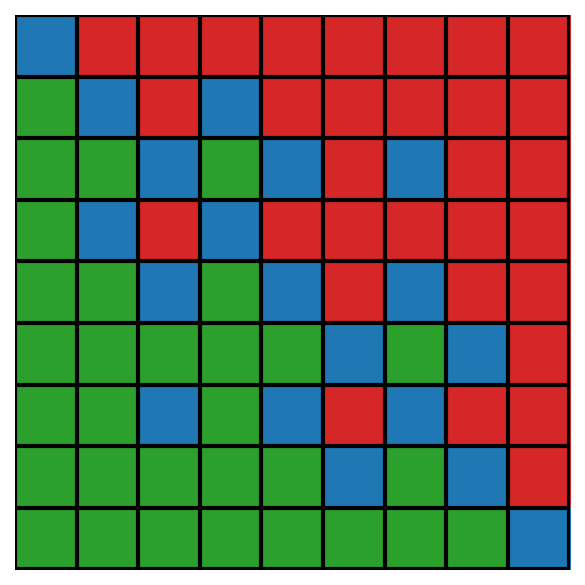

In [29]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.mej_plot(comet.get_MEJ())
plt.savefig('images/mej.pdf', bbox_inches='tight')
plt.show()

The following visualization is a plot of characteristic objects with alternatives. This one will work only in the case of 2 criteria.

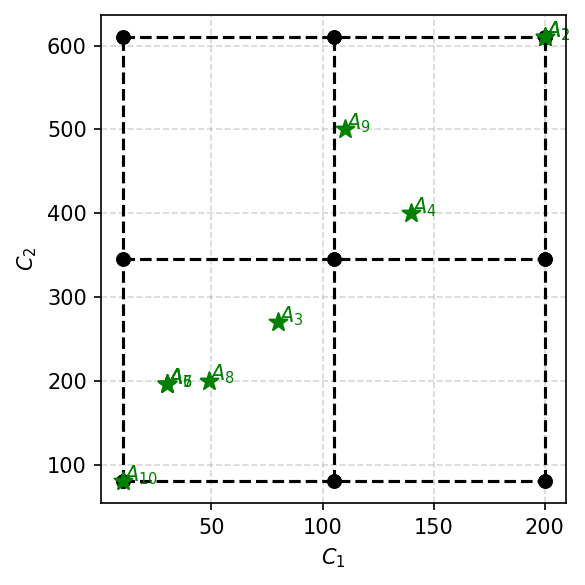

In [30]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.comet_2d_plot(cvalues, alts)
plt.savefig('images/comet2d.pdf', bbox_inches='tight')
plt.show()

It is also possible to add contourf which presents change of the preference function.

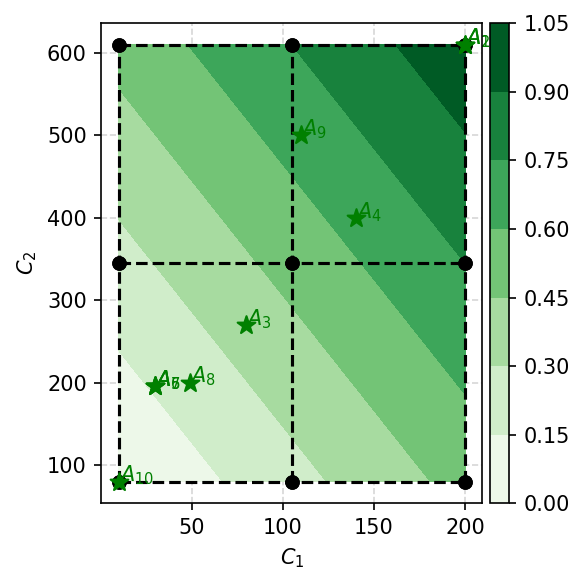

In [31]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)
visuals.comet_contourf(comet,
                       alts,
                       colorbar=True)
plt.savefig('images/comet_contourf.pdf', bbox_inches='tight')
plt.show()

There is also a function which draw TFNs functions for the built COMET. See next example.

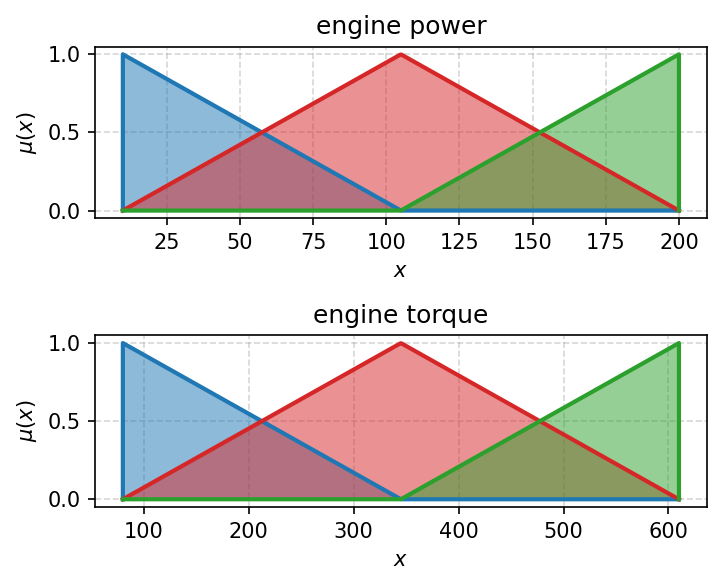

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(5, 4), dpi=150)
for i in range(2):
    visuals.comet_tfns(comet,
                       criterion_index=i,
                       criterion_name=criteria_names[i],
                       colors=['tab:blue', 'tab:red', 'tab:green'],
                       plot_kwargs=dict(lw=2),
                       ax=axes[i])
plt.tight_layout()
plt.savefig('images/comet_tfs.pdf', bbox_inches='tight')
plt.show()

There is also a 3d version of this plot that supports 3 criteria. Notice that the axis should be created with `projection='3d'` argument.

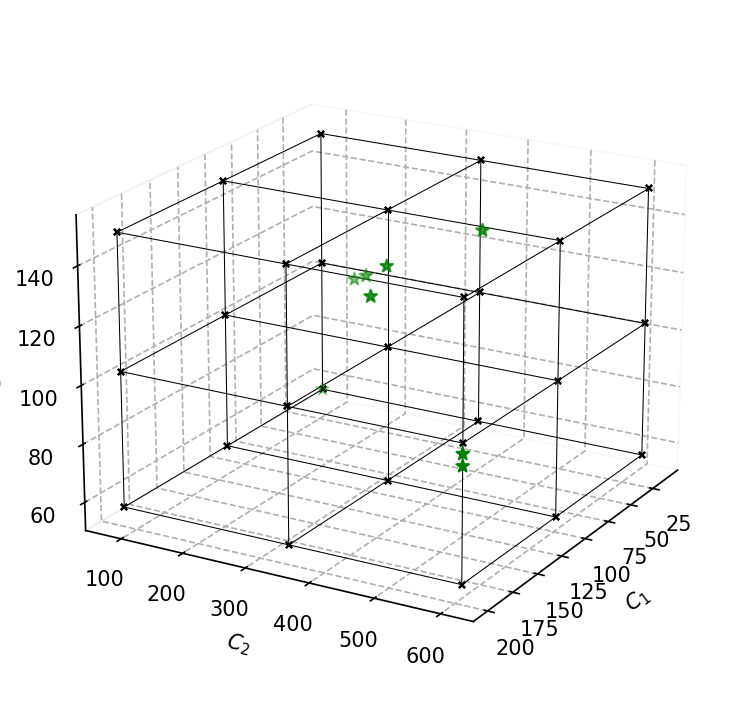

In [33]:
criteria_names = ['engine power', 'engine torque', 'max velocity']
alts = df[criteria_names].to_numpy()

cvalues = COMET.make_cvalues(alts)

fig, ax = plt.subplots(figsize=(5, 5), dpi=150, tight_layout=True, subplot_kw=dict(projection='3d'))
visuals.comet_3d_plot(cvalues, alts, ax=ax)
plt.savefig('images/comet3.pdf', bbox_inches='tight')
plt.show()

# Weights visualization

With our library is also possible to calculate criteria weights with different objective methods and visualize them on the bar diagrams as shown below.

In [34]:
from pymcdm import weights as w

In [35]:
# Get full decision matrix once again
alts = df[df.columns[3:]].to_numpy()

# Define list with several weighting methods
weighting_methods = [
    w.equal_weights,
    w.entropy_weights,
    w.standard_deviation_weights,
    w.gini_weights
]

weight_sets = []
for m in weighting_methods:
    weight_sets.append(m(alts))

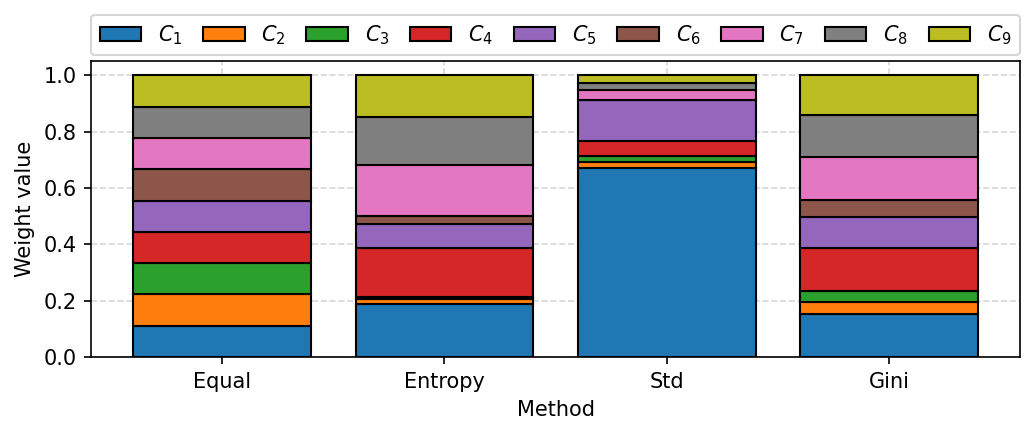

In [36]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=150, tight_layout=True)

visuals.weights_plot(weight_sets,
                     xticklabels=['Equal', 'Entropy', 'Std', 'Gini'],
                     legend_ncol=9,
                     ax=ax)
plt.savefig('images/weights.pdf', bbox_inches='tight')
plt.show()

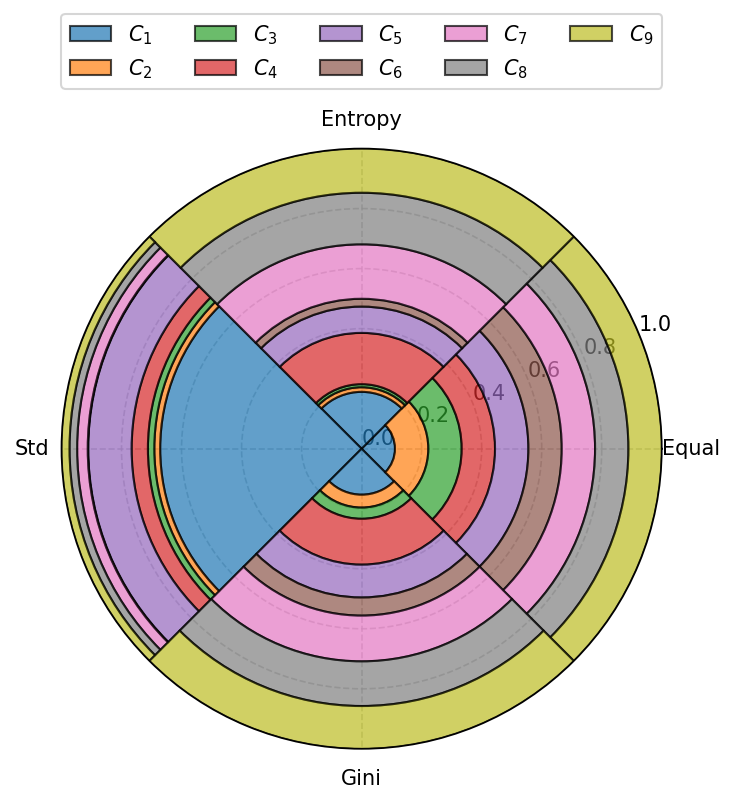

In [37]:
fig, ax = plt.subplots(figsize=(5, 6), dpi=150, tight_layout=True, subplot_kw=dict(projection='polar'))

visuals.polar_weights(weight_sets,
                      xticklabels=['Equal', 'Entropy', 'Std', 'Gini'],
                      legend_ncol=5,
                      ax=ax)
plt.tight_layout()
plt.savefig('images/weights_polar.pdf', bbox_inches='tight')
plt.show()

# PROMETHEE I partial ranking visualization

Our library also have an implementation of the PROMETHEE method which could build only a partial ranking. This ranking could be visualized as a graph or as a flows as it shown below.

In [38]:
from pymcdm.methods import PROMETHEE_II

prom = PROMETHEE_II(preference_function='usual')

In [39]:
# Once again create weights and types of criteria
weights = w.entropy_weights(alts)
types = np.array([1, 1, 1, 1, 1, -1, -1, 1, -1])

In [40]:
# You should pass promethee_I=True argument to get PROMETHEE I output
Fp, Fm = prom(alts, weights, types, promethee_I=True)

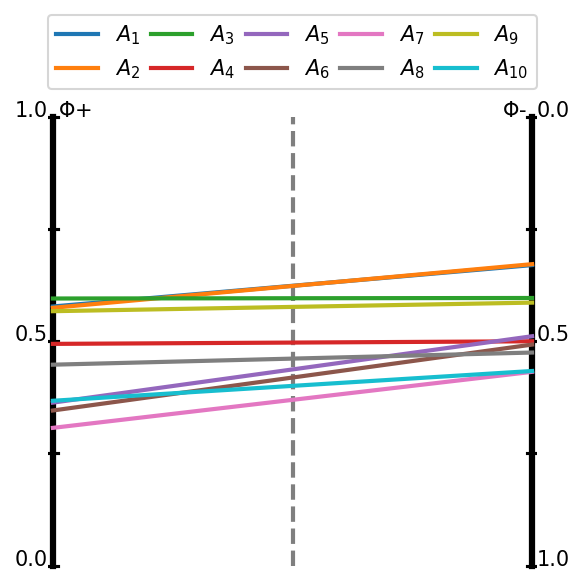

In [41]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)

visuals.promethee_I_flows(Fp, Fm)
plt.savefig('images/promethee_flows.pdf', bbox_inches='tight')
plt.show()

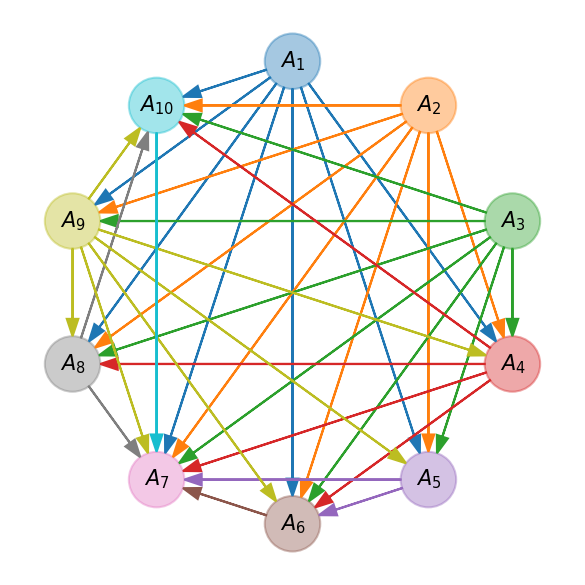

In [42]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150, tight_layout=True)

visuals.promethee_I_graph(Fp, Fm)
plt.savefig('images/promethee_graph.pdf', bbox_inches='tight')
plt.show()

# Visualization of many correlations

This function could be used to visualize the distribution of the correlations of many rankings. We will provide only a simple example to show how to use them.

In [43]:
data = np.array([
    np.random.rand(100),
    np.random.rand(100),
])

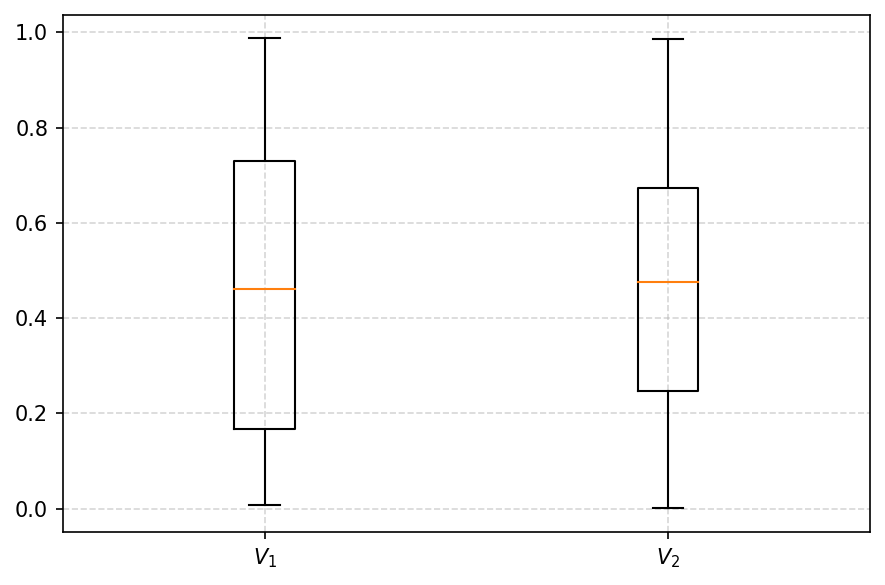

In [44]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150, tight_layout=True)

visuals.boxplot(data)
plt.savefig('images/boxplot.pdf', bbox_inches='tight')
plt.show()

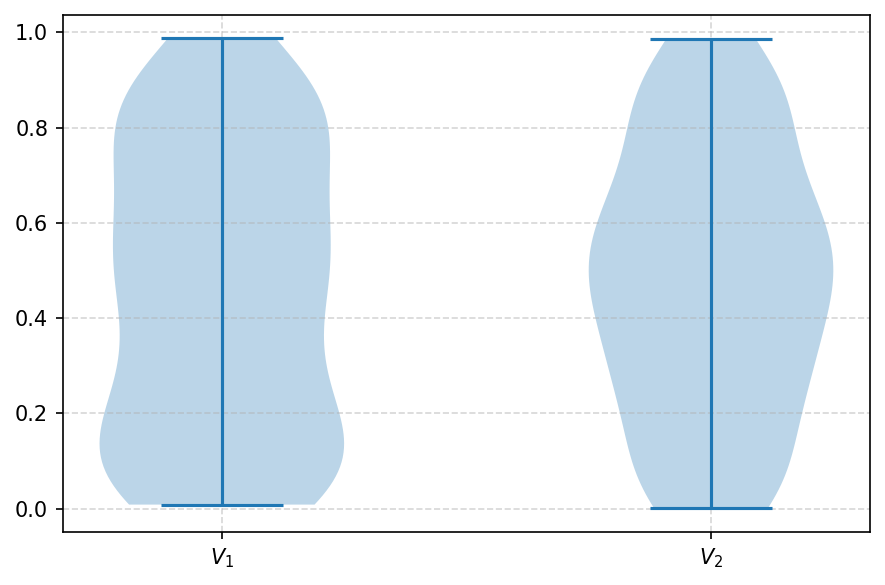

In [45]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150, tight_layout=True)

visuals.violin(data)
plt.savefig('images/boxplot.pdf', bbox_inches='tight')
plt.show()